In [5]:
import json
import pandas as pd
# import matplotlib.pyplot as plt
import tqdm
import networkx as nx
import numpy as np
import pickle

In [6]:
citations = pd.read_csv("papers.csv").fillna('')
citations

,Conference,Year,Title,DOI,Link,FirstPage,LastPage,PaperType,Abstract,AuthorNames-Deduped,AuthorNames,AuthorAffiliation,InternalReferences,AuthorKeywords,AminerCitationCount,CitationCount_CrossRef,PubsCited_CrossRef,Award
0,Vis,2022,Photosensitive Accessibility for Interactive D...,10.1109/TVCG.2022.3209359,http://dx.doi.org/10.1109/TVCG.2022.3209359,374,384,J,Accessibility guidelines place restrictions on...,Laura South;Michelle Borkin,Laura South;Michelle A. Borkin,"Northeastern University, USA;Northeastern Univ...",10.1109/TVCG.2011.185;10.1109/TVCG.2021.311482...,"accessibility,photosensitive epilepsy,photosen...",,1.0,63.0,
1,Vis,2022,HetVis: A Visual Analysis Approach for Identif...,10.1109/TVCG.2022.3209347,http://dx.doi.org/10.1109/TVCG.2022.3209347,310,319,J,Horizontal federated learning (HFL) enables di...,Xumeng Wang;Wei Chen 0001;Jiazhi Xia;Zhen Wen;...,Xumeng Wang;Wei Chen;Jiazhi Xia;Zhen Wen;Rongc...,"TMCC, CS, Nankai University, China;State Key L...",10.1109/TVCG.2015.2467618;10.1109/TVCG.2019.29...,"Federated learning,data heterogeneity,cluster ...",,3.0,43.0,
2,Vis,2022,Rigel: Transforming Tabular Data by Declarativ...,10.1109/TVCG.2022.3209385,http://dx.doi.org/10.1109/TVCG.2022.3209385,128,138,J,"We present Rigel, an interactive system for ra...",Ran Chen;Di Weng;Yanwei Huang;Xinhuan Shu;Jiay...,Ran Chen;Di Weng;Yanwei Huang;Xinhuan Shu;Jiay...,"State Key Lab of CAD&CG, Zhejiang University, ...",10.1109/TVCG.2021.3114830;10.1109/VAST47406.20...,"Data transformation,self-service data transfor...",,3.0,68.0,
3,Vis,2022,BeauVis: A Validated Scale for Measuring the A...,10.1109/TVCG.2022.3209390,http://dx.doi.org/10.1109/TVCG.2022.3209390,363,373,J,We developed and validated a rating scale to a...,Tingying He;Petra Isenberg;Raimund Dachselt;To...,Tingying He;Petra Isenberg;Raimund Dachselt;To...,"Université Paris-Saclay, CNRS, Inria, LISN, Fr...",10.1109/INFVIS.2005.1532128;10.1109/TVCG.2006....,"Aesthetics,aesthetic pleasure,validated scale,...",,1.0,79.0,
4,Vis,2022,NAS-Navigator: Visual Steering for Explainable...,10.1109/TVCG.2022.3209361,http://dx.doi.org/10.1109/TVCG.2022.3209361,299,309,J,The success of DL can be attributed to hours o...,Anjul Tyagi;Cong Xie;Klaus Mueller 0001,Anjul Tyagi;Cong Xie;Klaus Mueller,"Computer Science Department, Visual Analytics ...",10.1109/VAST.2012.6400490;10.1109/TVCG.2019.29...,"Deep Learning,Neural Network Architecture Sear...",,0.0,63.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,Vis,1990,Visualization and three-dimensional image proc...,10.1109/VISUAL.1990.146376,http://dx.doi.org/10.1109/VISUAL.1990.146376,144,"149, 469",C,The author applied image processing and volume...,Nahum D. Gershon,N.D. Gershon,"MITRE Corporation, Mclean, VA, USA",,,10.0,5.0,5.0,
3616,Vis,1990,Case study in scientific visualization: factor...,10.1109/VISUAL.1990.146415,http://dx.doi.org/10.1109/VISUAL.1990.146415,430,434,C,The problem of presenting and gaining deeper u...,Wayne E. Fordyce;Jeffrey Ventrella,W.E. Fordyce;J.J. Ventrella,"Research Computing Services, Syracuse Universi...",,,1.0,1.0,10.0,
3617,Vis,1990,Hierarchical triangulation using terrain features,10.1109/VISUAL.1990.146379,http://dx.doi.org/10.1109/VISUAL.1990.146379,168,175,C,A hierarchical triangulation built from a digi...,Lori L. Scarlatos;Theodosios Pavlidis,L. Scarlatos;T. Pavlidis,"Grumman Data Systems, Woodbury, NY, USA;Depart...",,,43.0,7.0,20.0,
3618,Vis,1990,A methodology for scientific data visualisatio...,10.1109/VISUAL.1990.146372,http://dx.doi.org/10.1109/VISUAL.1990.146372,114,123,C,A methodology for guiding the choice of visual...,Philip K. Robertson,P.K. Robertson,"Centre for Spatial Information Systems, Divisi...",,,4.0,13.0,21.0,


In [7]:
citations = citations.drop(columns=['Conference', 'FirstPage', 'LastPage', 'PaperType', 'AuthorNames', 'AuthorAffiliation', 'AuthorKeywords', 'AminerCitationCount', 'Award'])
citations.columns

Index(['Year', 'Title', 'DOI', 'Link', 'Abstract', 'AuthorNames-Deduped',
       'InternalReferences', 'CitationCount_CrossRef', 'PubsCited_CrossRef'],
      dtype='object')

In [4]:
with open("src/assets/papers.json", "w") as file:
    json.dump({"data": citations.to_dict(orient='records')}, file)

In [8]:
graph = nx.DiGraph()

for i, row in tqdm.tqdm(citations.iterrows()):
    graph.add_node(row['DOI'])
    
for i, row in tqdm.tqdm(citations.iterrows()):
    for ref in row['InternalReferences'].split(';'):
        if not ref: continue
        graph.add_edge(row['DOI'], ref)


3620it [00:00, 65480.04it/s]
3620it [00:00, 57245.01it/s]


In [14]:
layout = nx.kamada_kawai_layout(graph)

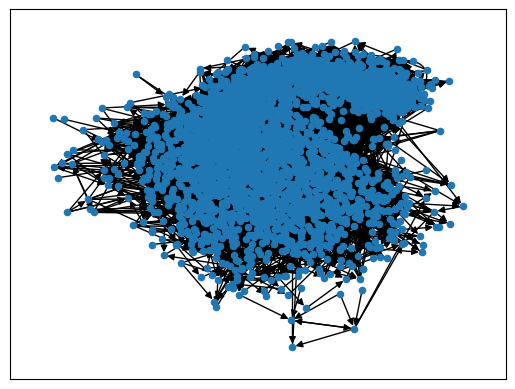

In [15]:
nx.draw_networkx(graph, pos=layout, with_labels=False, node_size=20)

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-distilroberta-v1").to('mps')

# Our sentences we like to encode
sentences = citations['Title'].values.tolist()

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences, batch_size=8)
with open("embeddings.pkl", "wb") as file:
    pickle.dump(embeddings, file)

/Users/vsivaram/miniconda3/envs/citation-network/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:

with open("embeddings.pkl", "rb") as file:
    embeddings = pickle.load(file)

In [39]:
import sys; sys.path.insert(0, '../../../../moving_scatterplot/notebook_widgets/emblaze')
from emblaze.datasets import *

# Create a UMAP for every year independently, and align to the next one

# umap_poses = {}
# for year in reversed(range(citations['Year'].min(), citations['Year'].max() + 1)):
#     print(year)
#     mask = citations['Year'] <= year
#     emb_set = Embedding({ 'position': embeddings[mask], 'color': citations[mask].Year }, ids=citations[mask].index)
#     projected = emb_set.project()
#     if year < citations['Year'].max():
#         projected = projected.align_to(umap_poses[year + 1])
#     emb_pos = projected.field('position')
#     projected = projected.copy_with_fields({
#         'position': (emb_pos - emb_pos.min(axis=0)) / (emb_pos.max(axis=0) - emb_pos.min(axis=0))
#     })

#     umap_poses[year] = projected

# Just one TSNE
emb_set = Embedding({ 'position': embeddings, 'color': citations.Year }, ids=citations.index)
projected = emb_set.project(method='tsne')
emb_pos = projected.field('position')
citations["emb_pos"] = ((emb_pos - emb_pos.min(axis=0)) / (emb_pos.max(axis=0) - emb_pos.min(axis=0))).astype(float).tolist()


In [34]:
# Store the UMAP positions per-row

umap_per_row = [{} for _ in citations.iterrows()]
for year in range(citations['Year'].min(), citations['Year'].max() + 1):
    mask = citations['Year'] <= year
    j = 0
    for i, row in citations.iterrows():
        if not mask[i]: continue
        umap_per_row[i][year] = umap_poses[year].field("position")[j].tolist()
        j += 1
umap_per_row[0]

citations['umap'] = umap_per_row

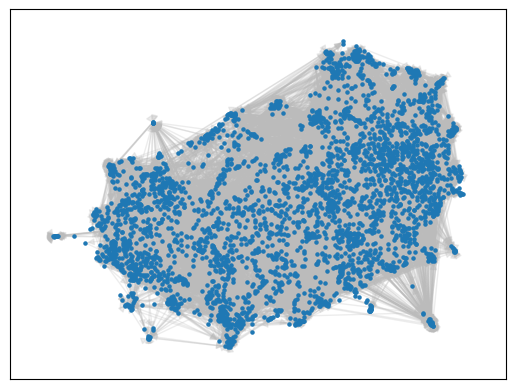

In [19]:
nx.draw_networkx(graph, pos={row['DOI']: umap_pos[i] for i, row in citations.iterrows()}, with_labels=False, node_size=5, edge_color="#bbbbbb44")

In [37]:
# calculate number of citations per year
min_year = citations['Year'].min()
max_year = citations['Year'].max()
num_citations = np.zeros((len(citations), max_year - min_year + 1), dtype=int)

for i, row in tqdm.tqdm(citations.iterrows()):
    for ref in row['InternalReferences'].split(';'):
        if not ref: continue
        ref_year = citations[citations['DOI'] == ref].iloc[0]['Year']
        num_citations[i, ref_year - min_year:] += 1
        
citations['CitationsByYear'] = num_citations.tolist()

3620it [00:03, 996.58it/s] 


In [43]:
from emblaze.utils import standardize_json

with open("src/assets/papers.json", "w") as file:
    json.dump({"data": standardize_json(citations.to_dict(orient='records')), 
               "min_year": int(min_year), 
               "max_year": int(max_year)}, file)

In [51]:
np.vstack(citations['emb_pos'].values)[:,0].min()

0.0

In [46]:
np.array(citations['emb_pos'])

array([list([0.19909290969371796, 0.265617311000824]),
       list([0.17035634815692902, 0.32209914922714233]),
       list([0.3298490047454834, 0.6367239356040955]), ...,
       list([0.9558748006820679, 0.5417284369468689]),
       list([0.4540897309780121, 0.345614492893219]),
       list([0.6433980464935303, 0.2850923240184784])], dtype=object)